# Run and Plot FluSight Forecasts (2024-2025 season)<a class="anchor" id="top"></a>

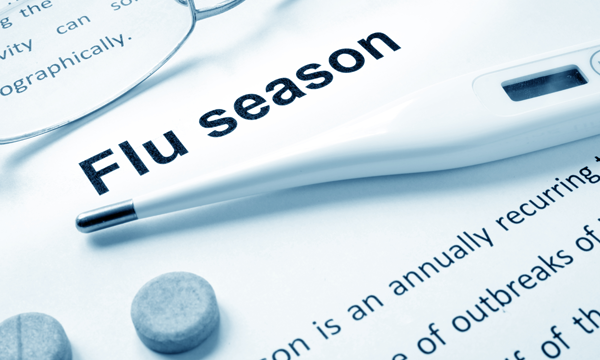

## Table of contents

* [Run forecast](#run-forecast)
* [Import forecast files](#import-forecast)
* [Plot fore quantiles](#plot-fore-quantiles)

In [1]:
import gc
import importlib
import os
from pathlib import Path
import sys
import time

import IPython.display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
# from matplotlib import ticker
# from matplotlib import dates
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

# MANUALLY ADD RTREND LIBRARY PATH
sys.path.append("../../Rtrend_project/")
# Move to project root directory
if os.path.basename(os.getcwd()) != "programs":
    os.chdir("..")  # Move to project root
print(f"Working directory: {os.getcwd()}")

from rtrend_forecast.reporting import get_rtrend_logger, SUCCESS
import rtrend_forecast.visualization as vis
import utils.flusight_tools as fst
import utils.truth_data_structs as tds

# ------

_LOGGER = get_rtrend_logger().getChild("jupyter")
# ---
# %matplotlib notebook
%matplotlib widget
mpl.rcParams["pdf.fonttype"] = 42

main_rc = mpl.rcParams.copy()

main_rc["patch.linewidth"] = 0.
aggr_ref_tlabel = pd.Timestamp("2023-10-08")  # Sunday 00am, turns epiweek

# Define and reset the matplotlib figures in the notebook
try: 
    for _fig in mpl_figs: plt.close(_fig)
except NameError: pass
finally: mpl_figs = list()
plt.close("all")
gc.collect()
fig_kwargs = dict(num=1, clear=True) # Based on: https://stackoverflow.com/questions/28757348/how-to-clear-memory-completely-of-all-matplotlib-plots


Working directory: /Users/pventura/NonCloudStorage/Flu_forecast/programs


# Run forecast <a class="anchor" id="run-forecast"></a>

[Back to top](#top)

In [2]:
do_run = False
do_export = True
# now_str = pd.Timestamp.now().isoformat()
now_str = (pd.Timestamp.now() - pd.Timedelta("3d")).isoformat()
# now_str = "2024-04-22"  # Date of the last forecast done
print(f"Now str = {now_str}")

if do_run:
    xt0 = time.time()
    cmd = f"source activate rtrend_dev && python flusight_forecast.py --now {now_str}"
    cmd += "" if do_export else " --no-export"
    os.system(cmd)
    xtf = time.time()
    print("----------")
    print(f"Total script execution time = {xtf - xt0:0.2f}s")
else:
    print("Skipped")

Now str = 2024-11-25T09:52:24.866843
Skipped


# Import forecast files <a class="anchor" id="import-forecast"></a>

In [4]:
# -------------------------------
# PARAMETERS
# -------------------------------
truth_data_file = Path("hosp_data/truth_latest.csv")
# now = pd.Timestamp(now_str)
now = pd.Timestamp.now()

# # --- Select output 
output_dir = Path("outputs/latest/")
flusight_output_file = Path("forecast_out/latest.csv")
now = pd.Timestamp(now_str)

# # # # # # # # # # # Past !! 
# output_dir = Path("outputs/flusight_2024-11-23/")
# flusight_output_file = Path("forecast_out/2024-11-23-CEPH-Rtrend_fluH.csv")
# # truth_data_file = Path("hosp_data/truth_latest.csv")

# # # Experimental
# output_dir = Path("outputs/tests/rtrend_refactor_after/")
# flusight_output_file = Path("forecast_out/tests/rtrend_refactor_after.csv")
# now = pd.Timestamp("2024-11-26")

# -------------------------------
# IMPORTS
# -------------------------------
importlib.reload(fst)
importlib.reload(tds)


obj = fst.FluSightGeneralOutputs(output_dir)
# truth = tds.FluDailyTruthData(truth_data_file)
truth = tds.FluWeeklyTruthData(truth_data_file, pop_data_path="aux_data/locations.csv")
dates = fst.FluSightDates(now)

fsobj = fst.FluSight2023Fore(flusight_output_file)

# TODO: The objects to hold the truth, forecast and hubverse forecast data should be revised!
#  They can have better patterns and be more compatible between one another.
    
obj.q_df

2024-11-24   2024-12-01    2024-12-08    2024-12-15  \
location_name quantile                                                        
Alabama       0.010       6.393575    48.059609     48.615881     48.244621   
              0.025       6.640670    50.097677     52.753945     54.144625   
              0.050       6.795104    52.291415     57.325969     61.586808   
              0.100       7.042199    54.824135     63.191380     71.503027   
              0.150       7.222887    56.862667     68.074588     79.533605   
...                            ...          ...           ...           ...   
US            0.850     589.597471  5010.345171   7682.676312  11295.600084   
              0.900     603.939301  5196.467522   8300.800759  12667.043982   
              0.950     625.470840  5486.704131   9300.034241  15024.454845   
              0.975     642.225471  5734.102834  10128.157444  17059.372748   
              0.990     662.578057  5990.259590  11031.071237  19282.775476   

                          2024-12-22    2024-12-29    2025-01-05  
location_name quantile                                            
Alabama       0.010        47.905175     46.669702     37.773984  
              0.025        55.129915     55.161574     45.804407  
              0.050        64.769697     66.647617     57.449517  
              0.100        79.091923     84.290178     74.959264  
              0.150        90.652866     99.945171     90.621979  
...                              ...           ...           ...  
US            0.850     15608.278010  20070.778960  20316.251393  
              0.900     18082.240198  23789.709741  24369.992936  
              0.950     22403.736877  30341.731623  31639.552702  
              0.975     26329.923528  36438.309068  38349.265108  
              0.990     30636.961532  43123.135215  46330.178530  

[1219 rows x 7 columns]

# Quantile forecats <a class="anchor" id="plot-fore-quantiles"></a>

In [5]:
rc = main_rc.copy()
importlib.reload(vis)

do_save_plots = True
do_open_plots = True
# dt_behind = pd.Timedelta("12w")
dt_behind = pd.Timedelta("120w")

with plt.rc_context(rc):
    use_states = obj.q_df.index.get_level_values("location_name").unique()
    num_states = len(use_states)
    with plt.ioff():
        fig, axes = vis.make_axes_seq(num_states, max_cols=1, total_width=15., ax_height=6., fig_kwargs=fig_kwargs)  # Wider panels
        mpl_figs.append(fig)
    
    _LOGGER.info("Plotting...")
    for i_ax, state_name in enumerate(use_states):
        ax = axes[i_ax]
        
#         truth_sr = truth.xs_state_weekly(state_name, aggr_ref_tlabel).loc[dates.now - dt_behind:]
        truth_sr = truth.xs_state(state_name).loc[dates.now - dt_behind:]
        
        # -()- From forecast submission file
        plot_df = fsobj.quantiles_df.xs(truth.state_name_to_id[state_name], level="location").T
        
#         # -()- From general dataset
#         q_df = obj.q_df.xs(state_name).copy()
#         plot_df = q_df.iloc[:, 1:]  # EXCLUDES FIRST WEEK (incomplete)
        
                
        # Plot commands
        # -------------
        # --- Truth series
#         ax.plot(truth_sr, "o-", ms=3)
        ax.plot(truth_sr)
    
        # --- Quantile forecats
        previous_week = plot_df.columns[0] - pd.Timedelta("1w")
        
        vis.plot_fore_quantiles_as_area(
            ax, plot_df,  
#             prepend_point=(previous_week, truth_sr[previous_week])
        )

        # Extra
        ax.set_title(f"{state_name} ({truth.state_name_to_id[state_name]})" )
        ax.text(  # R(t) synthesis method
            0.85, 0.85, obj.meta_dict["synth_method_used"].get(state_name, "[[no-method]]"),
            transform=ax.transAxes,
        )
        
        # NHSN data "disclaimer lines": report mandates
        ax.plot(2 * [pd.Timestamp("2024-05-01")], [0, truth_sr.max()], ":")
        ax.plot(2 * [pd.Timestamp("2024-11-01")], [0, truth_sr.max()], ":")
        
        ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator())

        ax.set_xlim(dates.now - dt_behind, dates.now + pd.Timedelta("4w"))
        vis.rotate_ax_labels(ax)
    
    fig.tight_layout()
    
    if do_save_plots:
        os.makedirs("tmp_figs/", exist_ok=True)
        fig.savefig(f"tmp_figs/ct_states.pdf")
        print(f"Saved to tmp_figs dir. Click the link below to open:")
        flink = IPython.display.FileLink("../tmp_figs/ct_states.pdf")
        display(flink)
        if do_open_plots:
            os.system("open tmp_figs/ct_states.pdf")
        
    else:  # Only displays if not saved
        display(fig.canvas)



[jupyter] INFO: Plotting...
Saved to tmp_figs dir. Click the link below to open:


/Users/pventura/NonCloudStorage/Flu_forecast/tmp_figs/ct_states.pdf

# Reproduction number

[Back to run](#run-forecast)

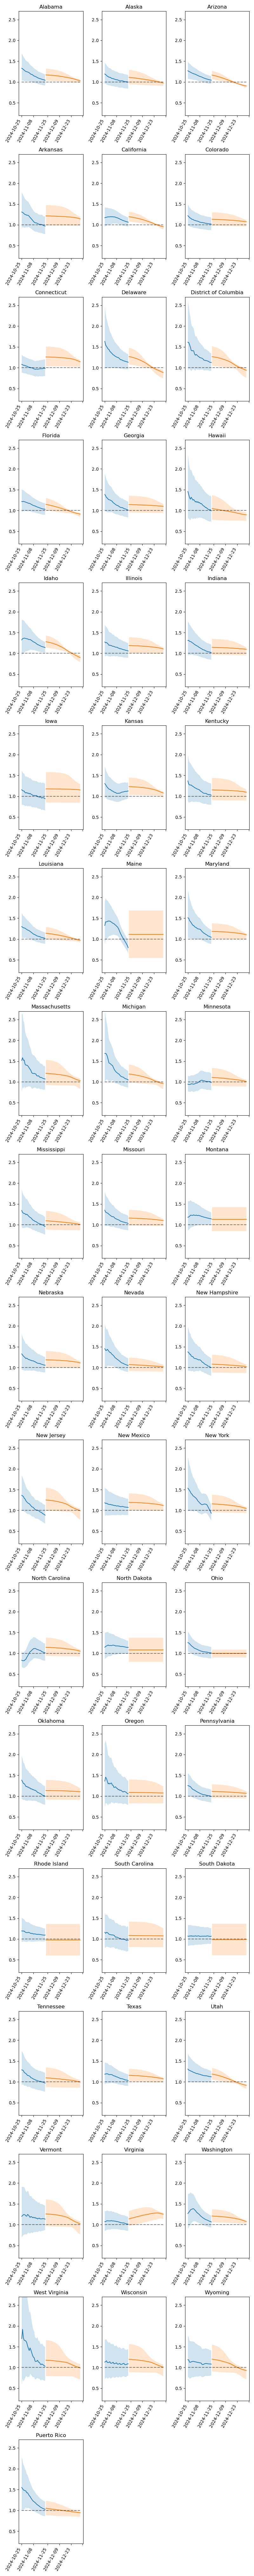

In [9]:

# ---------
rc = main_rc.copy()

do_save_plots = False

with plt.rc_context(rc):
    
#     # ----TEST
#     state_name = "California"
    use_states = obj.rt_past_df.index.get_level_values("location_name").unique()
    num_states = len(use_states)
    fig, axes = vis.make_axes_seq(num_states, total_width=8., ax_height=4.5)
    mpl_figs.append(fig)
    
    for i_ax, state_name in enumerate(use_states):
        ax = axes[i_ax]

        rt_past = obj.rt_past_df.xs(state_name, level="location_name").iloc[1:]
        rt_fore = obj.rt_fore_df.xs(state_name, level="location_name")

        # R(t) past
        ax.plot(rt_past["rt_past_median"])
        ax.fill_between(
            rt_past.index,
            rt_past["rt_past_low_q"],
            rt_past["rt_past_high_q"],
            alpha=0.2
        )

        # R(t) fore
        ax.plot(rt_fore["rt_fore_median"])
        ax.fill_between(
            rt_fore.index,
            rt_fore["rt_fore_low_q"],
            rt_fore["rt_fore_high_q"],
            alpha=0.2
        )
        # Reference lines
        ax.plot([rt_past.index[0], rt_fore.index[-1]], [1., 1.], "k--", alpha=0.5)

        # Extra
        ax.set_title(state_name)
        ax.set_ylim(0.2, 2.7)
        ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator())
        vis.rotate_ax_labels(ax)
    
    fig.tight_layout()
    
    if do_save_plots:
        fig.savefig(f"tmp_figs/rt_states.pdf")
    

# Tests - View categorical rate change forecasts

[Back to run](#run-forecast)

In [22]:
# #-- -- - Load submittable file


fore_df = pd.read_csv(
    "forecast_out/latest.csv", 
#     "forecast_out/APAGAR_latest_pre-horizon-change.csv", 
#     "forecast_out/tests/old_forecast_test.csv", 
    parse_dates=["reference_date", "target_end_date"])

color_map = plt.get_cmap("RdYlGn")
color_i_seq = np.array([1.00, 0.75, 0.50, 0.25, 0.00])

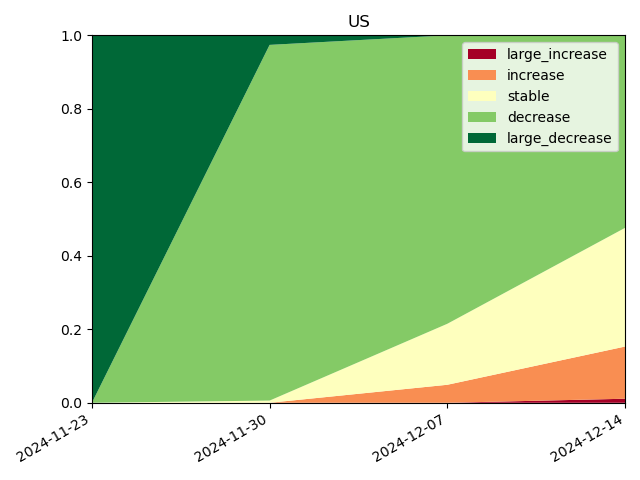

In [23]:
state_name = "US" # "Illinois"

# ----------
# -! NOTE will need to read the population file to convert between state ID and name

# # -()- "Decrease" as base
# rate_change_names = [
#     "large_decrease", "decrease", "stable", "increase", "large_increase"]
# color_i_seq = np.array([1.00, 0.75, 0.50, 0.25, 0.00])

# -()- "Increase" as base (looks better, as moving to "increase" is actually an increasing curve)
rate_change_names = [
    "large_increase", "increase", "stable", "decrease", "large_decrease"]
color_i_seq = np.array([0.0, 0.25, 0.50, 0.75, 1.0])


rate_change_id = {name: i for i, name in enumerate(rate_change_names)}  # Signature: r[i] = name


# ---------------

# -! TODO: also a version that aggregates some levels.

# --- Select data (state, rate change)
df = fore_df.loc[
      (fore_df["location"] == truth.state_name_to_id[state_name])
    & (fore_df["target"] == "wk flu hosp rate change")
    & (fore_df["output_type"] == "pmf")
]


# --- Convert values into a 2D table 
df.set_index(["output_type_id", "target_end_date"], inplace=True)
df.reindex()

value_table = df["value"].unstack("target_end_date").loc[rate_change_names]
#  ^  ^  Signature: df.loc[output_type_id, target_end_date]

# --------------- PLOT

rc = dict()
rc["axes.prop_cycle"] = mpl.cycler(color=color_map(color_i_seq))

with mpl.rc_context(rc):
    fig, ax = plt.subplots()

    ax.stackplot(value_table.columns, value_table, labels=rate_change_names)
    
    # TODO: set locator
    ax.legend()
    ax.set_title(state_name)
    ax.set_xlim(value_table.columns[0], value_table.columns[-1])
    ax.set_ylim(0., 1.0)
    
    ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(5))
    
    vis.rotate_ax_labels(ax, angle=30)
    fig.tight_layout()

In [10]:
# value_table.sort_index(axis=0, key=lambda s: rate_change_id[s])
value_table.loc[rate_change_names]

target_end_date  2024-01-27  2024-02-03  2024-02-10  2024-02-17
output_type_id                                                 
large_increase        0.000       0.000       0.000       0.000
increase              0.000       0.000       0.000       0.000
stable                0.002       0.021       0.022       0.011
decrease              0.579       0.543       0.947       0.805
large_decrease        0.419       0.436       0.031       0.184

----